<a href="https://colab.research.google.com/github/hafsa636/Uber-Data-Analysis-/blob/master/Uber_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New Section

# Import relevant libraries and define settings for plotting

In [ ]:
#Import relevant libraries and define settings for plotting.
%matplotlib inline
import sys
print(sys.version)

import numpy as np
print ('Numpy version:'), np.__version__

import pandas as pd
print ('Pandas version:'), pd.__version__

import matplotlib as mpl
import matplotlib.pyplot as plt
print ('Matplotlib version:'), mpl.__version__

import seaborn as sns
print ('Seaborn version:'), sns.__version__

import datetime
import time

sns.set()
pal = sns.hls_palette(10, h=.5)
sns.set_palette(pal)

#Avoid display of scientific notation and show precision of 4 decimals:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

3.6.9 (default, Jul 17 2020, 12:50:27) 
[GCC 8.4.0]
Numpy version:
Pandas version:
Matplotlib version:
Seaborn version:


In [ ]:
 !wget https://s3.amazonaws.com/nyc-tlc/misc/uber_nyc_data.csv

--2020-10-02 07:04:57--  https://s3.amazonaws.com/nyc-tlc/misc/uber_nyc_data.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.164.213
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.164.213|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1473327561 (1.4G) [application/octet-stream]
Saving to: ‘uber_nyc_data.csv’

uber_nyc_data.csv   100%[===================>]   1.37G  59.5MB/s    in 32s     

2020-10-02 07:05:29 (43.7 MB/s) - ‘uber_nyc_data.csv’ saved [1473327561/1473327561]



In [ ]:
#Load complete dataset from 9/1/2014 to 9/1/2015 with ~31M entries. No data dictionary is available.
#Source: http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml 
#direct source: !curl -O https://s3.amazonaws.com/nyc-tlc/misc/uber_nyc_data.csv
df_uber = pd.read_csv('uber_nyc_data.csv')

In [ ]:
df_uber.info() #near 31 million entries, ~1.4GB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30925738 entries, 0 to 30925737
Data columns (total 6 columns):
 #   Column           Dtype  
---  ------           -----  
 0   id               int64  
 1   origin_taz       object 
 2   destination_taz  object 
 3   pickup_datetime  object 
 4   trip_distance    float64
 5   trip_duration    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.4+ GB


In [ ]:
df_uber.head()

,id,origin_taz,destination_taz,pickup_datetime,trip_distance,trip_duration
0,252581,7C,6A,2014-09-01 09:00:00,4.2500,0:15:11
1,252582,7B,15,2014-09-01 18:00:00,10.1700,0:34:05
2,252583,11,2A,2014-09-01 17:00:00,4.0200,0:17:06
3,252584,3B,4A,2014-09-01 13:00:00,1.4600,0:06:32
4,252585,2A,10,2014-09-01 14:00:00,8.3100,0:26:17


In [ ]:
#The ID is unique
len(df_uber.id.unique())

30925738

## Check for missing or possibly erroneous data.

In [ ]:
#There are no duplicated rows (this takes a while to run):
len(df_uber[df_uber.duplicated() == True])

0

In [ ]:
#Show total null values per column. Use .any() in lieu of .sum() to just show which columns.
df_uber.isnull().sum() #Note: ~1.3 million destination entries (4%) are null (missing)

id                       0
origin_taz               0
destination_taz    1273023
pickup_datetime          0
trip_distance           38
trip_duration           38
dtype: int64

In [ ]:
arr1 = df_uber.origin_taz.unique() #28 unique origin codes
arr1

array(['7C', '7B', '11', '3B', '2A', '5B', '10', '2B', '9', '6B', '15',
       '4C', '5A', '8', '14', '4A', '7A', '1', '16', '3A', '2C', '6A',
       '12', '13', '3C', '4B', '5C', '17'], dtype=object)

In [ ]:
arr2 = df_uber.destination_taz.unique() #30 unique destination codes, same as origin except for nan and 18.
arr2

array(['6A', '15', '2A', '4A', '10', '4C', '7A', '3C', '5B', '14', '8',
       nan, '7C', '12', '2C', '1', '6B', '5C', '9', '3A', '2B', '11',
       '7B', '5A', '13', '4B', '18', '16', '3B', '17'], dtype=object)

In [ ]:
set(arr2) - set(arr1) #maybe code 18 represents EWR airport?

{'18', nan}

In [ ]:
#Check some of the data with missing destination. 
#One idea to fill missing values would be predict destination based on the other features.
df_uber[df_uber.destination_taz.isnull()].head()

,id,origin_taz,destination_taz,pickup_datetime,trip_distance,trip_duration
15,252596,6B,NaN,2014-09-01 17:00:00,11.6700,0:23:45
32,252613,9,NaN,2014-09-01 16:00:00,80.6900,1:59:37
63,252644,9,NaN,2014-09-01 18:00:00,23.0700,1:03:37
141,252722,9,NaN,2014-09-01 10:00:00,21.7300,0:41:12
148,252729,4B,NaN,2014-09-01 10:00:00,4.6200,0:14:55


In [ ]:
#There are 38 records with values missing for trip distance and duration, none of which are missing the destination.
df38 = df_uber[df_uber.trip_duration.isnull() & df_uber.trip_distance.isnull()]
df38.head()

,id,origin_taz,destination_taz,pickup_datetime,trip_distance,trip_duration
15155317,39535,2A,11,2015-04-25 12:00:00,nan,NaN
15245057,1009076,2A,2A,2015-04-26 01:00:00,nan,NaN
16519652,15028665,2A,7C,2015-04-29 21:00:00,nan,NaN
17148253,22250173,2A,2A,2015-04-12 02:00:00,nan,NaN
17297563,23716998,2C,11,2015-04-25 13:00:00,nan,NaN


In [ ]:
#All cases for which trip_duration is null match the cases for which trip_distance is also null:
len(df_uber[(df_uber.trip_duration.isnull() == False) & (df_uber.trip_distance.isnull())])

0


# Parse the pickup_datetime column to datetime type and create related features.

In [ ]:
#None of the pickup time data offer minutes or seconds precision
len(df_uber[df_uber.pickup_datetime.apply(lambda x: x[-5:] == '00:00') == False])

0

In [ ]:
def dateParser(s):
    """
    Function that takes a string in the format yyyy-mm-dd hh:mm:ss, and
    returns the same as a datetime object.
    """
    return datetime.datetime(int(s[0:4]), int(s[5:7]), int(s[8:10]), int(s[11:13]))

#Other methods were tried, all slower (the slowest being parsing while reading file in Pandas):
#return datetime.strptime(s, "%Y-%m-%d %H:%M:%S.%f")
#return np.datetime64(s) equivalent to: np.array(df_uber.pickup_datetime[0]).astype(np.datetime64)
#return pandas.Timestamp(s, "%Y-%m-%d %H:%M:%S.%f", tz='utc' )
#source: http://stackoverflow.com/questions/11136006/python-pandas-what-is-the-fastest-way-to-create-a-datetime-index

In [ ]:
#Apply parser to data
t0 = time.time()
df_uber['pu_date_hour'] = df_uber.pickup_datetime.apply(dateParser)
time.time() - t0

43.586652994155884

In [ ]:

#Data encompasses exactly 365 days from Sept 1st, 2014 to Sep 1st, 2015.
beginning = df_uber.pu_date_hour.min()
end = df_uber.pu_date_hour.max()
print (beginning, end, end - beginning)

2014-09-01 00:00:00 2015-09-01 00:00:00 365 days 00:00:00


In [ ]:
#Drop repeated column
df_uber = df_uber.drop('pickup_datetime', axis=1)

# Get the federal holidays for the period (useful for analyzing data later)

In [ ]:
#Get all federal holidays in the period
from pandas.tseries.holiday import USFederalHolidayCalendar

#if return_name is True, then name is series value and date is the series index, otherwise date is series value.
holidays = USFederalHolidayCalendar().holidays(beginning, end, return_name = True) 
holidays

2014-09-01                     Labor Day
2014-10-13                  Columbus Day
2014-11-11                  Veterans Day
2014-11-27                  Thanksgiving
2014-12-25                     Christmas
2015-01-01                 New Years Day
2015-01-19    Martin Luther King Jr. Day
2015-02-16                Presidents Day
2015-05-25                  Memorial Day
2015-07-03                      July 4th
dtype: object

In [ ]:
#Extract the weekday for each holiday
holidays.index.map(lambda x: x.strftime('%a'))

Index(['Mon', 'Mon', 'Tue', 'Thu', 'Thu', 'Thu', 'Mon', 'Mon', 'Mon', 'Fri'], dtype='object')

In [ ]:
#For completeness, let's add the day before and after the holidays (better: add day after if Thursday)
holidays_all = pd.concat([holidays, "Day After " + holidays.shift(1, 'D'), "Day Before " + holidays.shift(-1, 'D')])
holidays_all = holidays_all.sort_index()
holidays_all.head(10)

2014-08-31       Day Before Labor Day
2014-09-01                  Labor Day
2014-09-02        Day After Labor Day
2014-10-12    Day Before Columbus Day
2014-10-13               Columbus Day
2014-10-14     Day After Columbus Day
2014-11-10    Day Before Veterans Day
2014-11-11               Veterans Day
2014-11-12     Day After Veterans Day
2014-11-26    Day Before Thanksgiving
dtype: object

# Create other date and time features.

In [ ]:
#Create a column with the date, without the time. This will be useful later.
t0 = time.time()
df_uber['pu_date'] = pd.Series(map(lambda x: x.astype('datetime64[D]'), df_uber['pu_date_hour'].values))
#df_uber['pu_date'] = df_uber['pu_date_hour'].dt.date #this is way less memory effective and 11 sec slower to execute
time.time() - t0

49.852537393569946

In [ ]:
#Get month and year from pick up timestamp
df_uber['year'] = df_uber['pu_date_hour'].dt.year
df_uber['month'] = df_uber['pu_date_hour'].dt.month

In [ ]:

#Get trip pick up day of the month
t0 = time.time()
df_uber['day'] = df_uber['pu_date_hour'].dt.day #.apply(lambda x: x.day) = 105 seconds vs < 2 seconds with dt
time.time() - t0

2.863508939743042

In [ ]:
#Get trip pick up hour from timestamp
t0 = time.time()
df_uber['hour'] = df_uber['pu_date_hour'].dt.hour #< 2 seconds vs 101 seconds using apply lambda
time.time() - t0

2.890536069869995

In [ ]:
#Get trip pick up weekday from timestamp
t0 = time.time()
df_uber['weekday'] = df_uber['pu_date_hour'].dt.dayofweek
time.time() - t0

3.1835649013519287

In [ ]:
df_uber.weekday.value_counts() #Monday = 0, Sunday = 6

5    5142832
4    4805002
3    4625511
6    4331195
2    4301537
1    4010434
0    3709227
Name: weekday, dtype: int64

In [ ]:
df_uber.head()

,id,origin_taz,destination_taz,trip_distance,trip_duration,pu_date_hour,pu_date,year,month,day,hour,weekday
0,252581,7C,6A,4.2500,0:15:11,2014-09-01 09:00:00,2014-09-01,2014,9,1,9,0
1,252582,7B,15,10.1700,0:34:05,2014-09-01 18:00:00,2014-09-01,2014,9,1,18,0
2,252583,11,2A,4.0200,0:17:06,2014-09-01 17:00:00,2014-09-01,2014,9,1,17,0
3,252584,3B,4A,1.4600,0:06:32,2014-09-01 13:00:00,2014-09-01,2014,9,1,13,0
4,252585,2A,10,8.3100,0:26:17,2014-09-01 14:00:00,2014-09-01,2014,9,1,14,0


In [ ]:
df_uber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30925738 entries, 0 to 30925737
Data columns (total 12 columns):
 #   Column           Dtype         
---  ------           -----         
 0   id               int64         
 1   origin_taz       object        
 2   destination_taz  object        
 3   trip_distance    float64       
 4   trip_duration    object        
 5   pu_date_hour     datetime64[ns]
 6   pu_date          datetime64[ns]
 7   year             int64         
 8   month            int64         
 9   day              int64         
 10  hour             int64         
 11  weekday          int64         
dtypes: datetime64[ns](2), float64(1), int64(6), object(3)
memory usage: 2.8+ GB


# Transform trip duration data.

In [ ]:
uniq_dur = df_uber[df_uber.trip_duration.isnull() == False].trip_duration.unique() #19393

In [ ]:
#Among unique duration strings, find how many represent >= 10h of duration:
long_duration = [] #>= 10 hours or 600 minutes
for item in uniq_dur:
    if len(item) != 7:
        long_duration.append(item)

#long_duration
print (len(long_duration))

386


In [ ]:
#Check for the most unusual strings for trip duration: some erroneous entries need to be addressed
for item in long_duration:
    if len(item) > 8:
        print (item)

172032:14:50
172032:39:03
136:25:12
172032:17:45
172032:19:27
119:53:35
120:49:05


In [ ]:
def duration_to_minutes(s):
    """
    Function that takes a string with the hh:mm:ss format and
    returns the integer equivalent of the total time in minutes, 
    or zero for missing values in a Pandas dataframe.
    """
    if pd.isnull(s):
        val = 0 #note: this fills with 0 the 38 instances with null (missing) values
    else:
        hms = s.split(':')
        val = int(hms[0])*60 + int(hms[1]) + int(hms[2])/60.0
    return val

In [ ]:
#Transform the trip duration string into trip duration in minutes:
t0 = time.time()
df_uber['duration_min'] = df_uber.trip_duration.apply(duration_to_minutes) 
time.time() - t0

42.00506377220154

In [ ]:
df_uber.head()

,id,origin_taz,destination_taz,trip_distance,trip_duration,pu_date_hour,pu_date,year,month,day,hour,weekday,duration_min
0,252581,7C,6A,4.2500,0:15:11,2014-09-01 09:00:00,2014-09-01,2014,9,1,9,0,15.1833
1,252582,7B,15,10.1700,0:34:05,2014-09-01 18:00:00,2014-09-01,2014,9,1,18,0,34.0833
2,252583,11,2A,4.0200,0:17:06,2014-09-01 17:00:00,2014-09-01,2014,9,1,17,0,17.1000
3,252584,3B,4A,1.4600,0:06:32,2014-09-01 13:00:00,2014-09-01,2014,9,1,13,0,6.5333
4,252585,2A,10,8.3100,0:26:17,2014-09-01 14:00:00,2014-09-01,2014,9,1,14,0,26.2833


# Replace missing values with mean distance and duration for respective origin-destination.

In [ ]:
#Get the mean distance and duration for each origin-destination pair
df_DistDur = df_uber.groupby(['origin_taz', 'destination_taz'])[['trip_distance', 'duration_min']].mean()

In [ ]:
df_DistDur.head()

trip_distance  duration_min
origin_taz destination_taz                             
1          1                       1.4219       10.5655
           10                      3.6508       17.9776
           11                      5.0937       22.4899
           12                      8.8878       29.1024
           13                     11.5831       32.1568

In [ ]:
#Replace 38 missing values with the average distance and duration for the respective origin-destination pair
for i in df38.index:
    orig = df_uber.loc[i, 'origin_taz']
    dest = df_uber.loc[i, 'destination_taz']
    df_uber.loc[i, 'trip_distance'] = df_DistDur.loc[orig, dest].trip_distance
    df_uber.loc[i, 'duration_min'] = df_DistDur.loc[orig, dest].duration_min

# Calculate average speed for each trip.

In [ ]:
#Calculate average trip speed (mph) to help in understanding outliers (like trips with duration >10 h):
df_uber['trip_mph_avg'] = df_uber.trip_distance/(df_uber.duration_min/60.0)

In [ ]:
#Check that trip_distance and duration_min have been replaced, and trip speed has been calculated:
df_uber.iloc[df38.index, :].head()

,id,origin_taz,destination_taz,trip_distance,trip_duration,pu_date_hour,pu_date,year,month,day,hour,weekday,duration_min,trip_mph_avg
15155317,39535,2A,11,3.9368,NaN,2015-04-25 12:00:00,2015-04-25,2015,4,25,12,5,19.7321,11.9708
15245057,1009076,2A,2A,1.3588,NaN,2015-04-26 01:00:00,2015-04-26,2015,4,26,1,6,10.9195,7.4660
16519652,15028665,2A,7C,9.0394,NaN,2015-04-29 21:00:00,2015-04-29,2015,4,29,21,2,30.2041,17.9566
17148253,22250173,2A,2A,1.3588,NaN,2015-04-12 02:00:00,2015-04-12,2015,4,12,2,6,10.9195,7.4660
17297563,23716998,2C,11,4.8331,NaN,2015-04-25 13:00:00,2015-04-25,2015,4,25,13,5,24.3851,11.8918


In [ ]:
#Drop redundant trip_duration columns
df_uber = df_uber.drop('trip_duration', axis=1)
df_uber = df_uber.drop('pu_date_hour', axis=1)

# Calculate Estimated Revenue per Trip.

In [ ]:
#Source: http://uberestimate.com/prices/New-York-City/ for Uber X
base_fare = 2.55
per_minute = 0.35
per_mile = 1.75
min_fare = 8

In [ ]:
#When not possible to work with Pandas dataframe directly (due to memory usage), go back to array!
#test = df_uber[['duration_min', 'trip_distance']].values

In [ ]:
#def est_revenue(arr):
  # rev = base_fare + arr[0] * per_minute + arr[1] * per_mile
  # return rev if rev > min_fare else min_fare

In [ ]:
#df_uber['est_revenue'] = pd.Series(map(lambda x: est_revenue(x), test))

In [ ]:
#Using eval() is even more efficient for large datasets than resorting to Numpy! 
#Local variables must be followed by @. Only for arithmetic, cannot use if statement, for example.
df_uber['est_revenue'] = df_uber.eval('@base_fare + duration_min * @per_minute + trip_distance * @per_mile')
df_uber.loc[df_uber.est_revenue < 8, 'est_revenue'] = min_fare

In [ ]:
df_uber.head()

,id,origin_taz,destination_taz,trip_distance,pu_date,year,month,day,hour,weekday,duration_min,trip_mph_avg,est_revenue
0,252581,7C,6A,4.2500,2014-09-01,2014,9,1,9,0,15.1833,16.7947,15.3017
1,252582,7B,15,10.1700,2014-09-01,2014,9,1,18,0,34.0833,17.9032,32.2767
2,252583,11,2A,4.0200,2014-09-01,2014,9,1,17,0,17.1000,14.1053,15.5700
3,252584,3B,4A,1.4600,2014-09-01,2014,9,1,13,0,6.5333,13.4082,8.0000
4,252585,2A,10,8.3100,2014-09-01,2014,9,1,14,0,26.2833,18.9702,26.2917


# Queries for Checking Data Consistency.

# A closer look of the anomalous cases of trip duration.

In [ ]:
#Check for very long duration entries, and effect on revenue numbers:

#>=100h:
print (len(df_uber[(df_uber.duration_min >= 6000)])) #7

#Greater than 100h: 7 entries (erroneous): system error? fraud? Total revenue is relevant: $14,459,978 (2.4% of total)
#172032:14:50 #probable system error: distance < 10 miles
#172032:39:03 #probable system error: distance < 10 miles
#136:25:12 #short distance
#172032:17:45 #probable system error: distance < 10 miles
#172032:19:27 #probable system error: distance < 10 miles
#119:53:35 #long distance, incorrect destination?
#120:49:05 #long distance, this entry has missing destination

#>16h and <100h : 116 entries
df_uber[(df_uber.duration_min > 960) & (df_uber.duration_min < 6000)].est_revenue.sum() #$78,070 total revenue

#The effect on revenue is relevant only for the trips higher than 100h of duration, which are most likely a result of 
#some system error (as seen above), or perhaps fraud, therefore these 7 entries will be excluded from the dataset for
#analysis. However, assuming that driving more than 16h (960 minutes) non-stop per day represents unreliable data, 
#these additional 116 cases will also be excluded from analysis. These 123 data points warrant more in-depth internal
#investigation to bring light to what may have caused them.

7


78069.74916666666

In [ ]:
#Were the trips with distance and duration equal to zero actually cancelled (didn't happen)? 

print (len(df_uber[(df_uber.duration_min == 0) & (df_uber.trip_distance == 0)])) #24866
#There is at least one case almost daily. The 24866 cases represent a revenue of $198,928, based on $8 minimum fare.

#Note that origin and destination are the same, except for 910 trips: did these trips in fact occur?
df_uber[(df_uber.duration_min == 0) & (df_uber.trip_distance == 0) & (df_uber.origin_taz != df_uber.destination_taz)].\
head()#910

#There is generally a fee associated with trip cancellation, so unless these trips represent a system error or fraud,
#there was no loss of the minimum fare revenue.

24866


,id,origin_taz,destination_taz,trip_distance,pu_date,year,month,day,hour,weekday,duration_min,trip_mph_avg,est_revenue
21726,274307,4B,8,0.0000,2014-09-29,2014,9,29,17,0,0.0000,nan,8.0000
21847,274428,4C,2A,0.0000,2014-09-29,2014,9,29,17,0,0.0000,nan,8.0000
21909,274490,5C,6A,0.0000,2014-09-29,2014,9,29,19,0,0.0000,nan,8.0000
22179,274760,11,4A,0.0000,2014-09-29,2014,9,29,17,0,0.0000,nan,8.0000
22359,274940,3C,1,0.0000,2014-09-30,2014,9,30,14,1,0.0000,nan,8.0000


In [ ]:
#Check cases with distance equal to zero but duration greater than zero:

print (len(df_uber[(df_uber.duration_min > 0) & (df_uber.trip_distance == 0)])) #85515

#The median duration for trips with zero distance is 10 seconds (mean= 2.4 minutes), so most of these 85,515 cases 
#possibly represent trips that were cancelled right after they were registered.

#3873 trips of the 85,515 cases show pick up and drop off in different taxi zones 
#(median duration: 10 seconds, mean: 4.5 minutes).

#Let's check the small dataset (277) out of the 3873 cases with duration > 5 minutes, but distance equal to zero:
#Maybe these cases represent some error with registering the distance traveled?
df_uber[(df_uber.duration_min >= 5) & (df_uber.trip_distance == 0) &(df_uber.origin_taz != df_uber.destination_taz)]\
.head(10)

85515


,id,origin_taz,destination_taz,trip_distance,pu_date,year,month,day,hour,weekday,duration_min,trip_mph_avg,est_revenue
882890,18153735,1,2A,0.0000,2014-09-28,2014,9,28,1,6,7.1167,0.0000,8.0000
3223424,29754237,4C,6A,0.0000,2014-10-05,2014,10,5,20,6,7.5167,0.0000,8.0000
18154210,2023861,1,4C,0.0000,2015-05-28,2015,5,28,12,3,27.2000,0.0000,12.0700
18829282,8785823,4B,8,0.0000,2015-05-26,2015,5,26,16,1,38.7833,0.0000,16.1242
19414939,14586763,4C,5C,0.0000,2015-05-28,2015,5,28,18,3,11.0167,0.0000,8.0000
20674992,27149481,4C,1,0.0000,2015-05-28,2015,5,28,11,3,32.8500,0.0000,14.0475
21376632,3045165,1,6B,0.0000,2015-06-28,2015,6,28,23,6,32.8167,0.0000,14.0358
21472913,4006319,15,4A,0.0000,2015-06-26,2015,6,26,10,4,55.7333,0.0000,22.0567
21517547,4482860,1,5C,0.0000,2015-06-23,2015,6,23,13,1,22.3500,0.0000,10.3725
21727436,6421520,6B,NaN,0.0000,2015-06-26,2015,6,26,9,4,78.2333,0.0000,29.9317


# A closer look of the anomalous cases for the calculated average trip speed.

In [ ]:
#Check the trips with average speed slower than walking (3mph).

print (len(df_uber[df_uber.trip_mph_avg <= 3])) #262,666 cases

#Considering that some really bad traffic is possible, let's check the proportion of cases that fall under 
#2 miles or less traveled distance:
df_uber[(df_uber.trip_mph_avg <= 3) & (df_uber.trip_distance <= 2)].head(10) #246,225, or ~94% of all trips with < 3mph

#0.8% of cases from the entire dataset have calculated speed < 3mph : really bad traffic cases, interrupted trips, 
#or fraud? We will assume they're mostly really bad traffic cases or interrupted trips for this analysis.

262666


,id,origin_taz,destination_taz,trip_distance,pu_date,year,month,day,hour,weekday,duration_min,trip_mph_avg,est_revenue
82,252663,14,14,0.0200,2014-09-01,2014,9,1,11,0,1.3333,0.9000,8.0000
120,252701,2A,2A,1.5100,2014-09-01,2014,9,1,20,0,33.8833,2.6739,17.0517
271,252852,8,8,0.0000,2014-09-01,2014,9,1,16,0,0.5000,0.0000,8.0000
542,253123,4C,4C,0.0500,2014-09-02,2014,9,2,17,1,1.1000,2.7273,8.0000
554,253135,2A,2A,0.0000,2014-09-02,2014,9,2,9,1,2.6833,0.0000,8.0000
605,253186,2A,2A,0.0500,2014-09-02,2014,9,2,20,1,1.4500,2.0690,8.0000
839,253420,2A,2A,0.4700,2014-09-02,2014,9,2,13,1,10.5833,2.6646,8.0000
896,253477,5C,6B,0.9900,2014-09-02,2014,9,2,17,1,22.1833,2.6777,12.0467
945,253526,14,14,0.0400,2014-09-02,2014,9,2,2,1,1.4000,1.7143,8.0000
1260,253841,4A,4A,0.0600,2014-09-02,2014,9,2,20,1,1.3500,2.6667,8.0000


In [ ]:

#Among the trips with very slow speed (< 3 mph), the most suspicious cases are perhaps those that show very long
#duration. Let's say that 1.5h would have been enough, in most situations, to get outside of some traffic gridlock, 
#then part of these cases should be investigated more in depth, especially because they represent a significant 
#share of the revenue ($850K).

df_uber[(df_uber.trip_mph_avg <= 3) & (df_uber.duration_min > 90) & (df_uber.duration_min <= 960)].head(10)#8393 cases

#Due to the lack of specific domain knowledge about the system that has generated this data, and unavailability of 
#more detailed trip information, these cases will be disregarded as suspicious in this analysis. It's possible, 
#for example, that some of the cases represent a driver waiting for a passenger during a trip, even though this is 
#not a typical behaviour in ride sharing.

,id,origin_taz,destination_taz,trip_distance,pu_date,year,month,day,hour,weekday,duration_min,trip_mph_avg,est_revenue
539,253120,5B,10,8.3400,2014-09-02,2014,9,2,11,1,173.3667,2.8864,77.8233
7798,260379,6A,6A,6.0100,2014-09-11,2014,9,11,12,3,128.1500,2.8139,57.9200
14734,267315,6B,5C,9.0800,2014-09-19,2014,9,19,13,4,196.2500,2.7761,87.1275
14996,267577,4C,6A,5.4800,2014-09-20,2014,9,20,15,5,110.7000,2.9702,50.8850
17131,269712,2A,NaN,4.8800,2014-09-21,2014,9,21,20,6,100.4667,2.9144,46.2533
21955,274536,6B,6B,2.9700,2014-09-29,2014,9,29,12,0,91.0833,1.9565,39.6267
22567,275148,4C,4C,1.3700,2014-09-30,2014,9,30,14,1,106.4833,0.7720,42.2167
24080,736706,6B,3A,6.0500,2014-09-02,2014,9,2,16,1,243.2167,1.4925,98.2633
27977,740603,4C,2B,4.9900,2014-09-07,2014,9,7,18,6,129.9500,2.3040,56.7650
29077,741703,4A,5A,7.9400,2014-09-08,2014,9,8,15,0,208.4500,2.2854,89.4025


# Filter Dataset, Define Functions, and Load Methods to be Used to Create Visualizations.

In [ ]:
#A few data points represent the zeroth hour of Sep, 2015, extending the time period beyond exactly 365 days:
len(df_uber[df_uber.pu_date == datetime.datetime(2015, 9, 1)]) #1852 data points to be censored for convenience.

1852

In [ ]:
#Create dataframe to be used for visualization with exactly 365 days of data, and max trip duration of 16h:
df_viz = df_uber[(df_uber.pu_date != datetime.datetime(2015, 9, 1)) & (df_uber.duration_min <= 960)].copy() #1975 cases

In [ ]:
#Descriptive statistics for numerical features:
df_viz[['duration_min', 'trip_distance', 'trip_mph_avg', 'est_revenue']].describe()

,duration_min,trip_distance,trip_mph_avg,est_revenue
count,30923763.0000,30923763.0000,30898897.0000,30923763.0000
mean,20.9923,5.1996,13.5071,19.2419
std,16.0846,6.1308,11.7569,15.0809
min,0.0000,0.0000,0.0000,8.0000
25%,10.8500,1.6900,8.4098,9.5733
50%,17.2333,3.0900,11.4488,14.3508
75%,26.6833,6.2300,16.2667,23.0308
max,959.3000,568.5700,22548.0000,1225.8583


In [ ]:
len(df_viz[(df_viz.month==8)&(df_viz.year==2015)])

3368404

In [ ]:
import matplotlib.mlab as mlab

In [ ]:
!pip install plotly as py

In [ ]:
!pip install chart_studio

     |████████████████████████████████| 71kB 2.0MB/s 


In [ ]:
import chart_studio.plotly as py

In [ ]:
from matplotlib.ticker import FuncFormatter #Call formatter function to format tick values
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox) #Create image box
from matplotlib._png import read_png #Load png file
from matplotlib.patches import Ellipse #Draw ellips

In [ ]:

#Create functions to format tick numbers
def thousands_comma(x, pos):
    """
    Args are the value and tick position. 
    Returns number with thousands comma and no decimals.
    """
    return '{:,.0f}'.format(x) #this is the new syntax for formatting

In [ ]:
def thousands_format(x, pos):
    """
    Args are the value and tick position. 
    Returns number of thousands with one decimal, and K in lieu of 3 zeros.
    """
    return '{:.0f}{}'.format(x * 1e-3, 'K') #old syntax: '%1.0fK' % (x * 1e-3)

In [ ]:

def millions_format(x, pos):
    """
    Args are the value and tick position. 
    Returns number of millions with one decimal, and M in lieu of 6 zeros.
    """
    return '{:.1f}{}'.format(x * 1e-6, 'M')

In [ ]:
def millions_currency(x, pos):
    """
    Args are the value and tick position. 
    Returns number of millions with a $ sign, M in lieu of 6 zeros, and no decimals.
    """
    return '{}{:.0f}{}'.format('$', x * 1e-6, 'M')

In [ ]:
#Define robust function to automatically add annotated labels on bar plots.
#Inspiration from http://composition.al/blog/2015/11/29/a-better-way-to-add-labels-to-bar-charts-with-matplotlib/

def annotate_labels(ax, labels_list, **kwargs):
    """
    Function to automatically add labels on bar charts.
    It takes a plot axis, an ordered list of labels, and text kwargs.
    """
    
    # Get y-axis height to calculate label position from.
    (y_bottom, y_top) = ax.get_ylim()
    y_height = y_top - y_bottom
    
    rects = ax.patches

    for rect, label in zip(rects, labels_list):
        height = rect.get_height()
        p_height = (height / y_height) # Fraction of axis height taken up by this rectangle
        label_position = height + (y_height * 0.01)
        
        # If we can fit the label above the column, do that;
        # otherwise, put it inside the column (or else, change ylim)
        #if p_height > 0.95:
        #    label_position = height - (y_height * 0.05)
        #else:
        #    label_position = height + (y_height * 0.01)

        ax.text(rect.get_x() + rect.get_width()/2., label_position, label, kwargs)
    return None

# Visualizing the demand: number of Uber trips per day.

In [ ]:
#Create a plotting dataframe with counts (number of trips) grouped by day:
byDate = df_viz.groupby('pu_date')['id'].count() #365 complete entries
byDate.head()

pu_date
2014-09-01    31592
2014-09-02    41496
2014-09-03    46339
2014-09-04    53402
2014-09-05    59718
Name: id, dtype: int64

In [ ]:
byDate['2014-10-28': '2014-11-05'] #an uptick in rides on 11/1, the day before the NYC marathon!

pu_date
2014-10-28     52084
2014-10-29     61082
2014-10-30     66369
2014-10-31     71787
2014-11-01    104450
2014-11-02     57289
2014-11-03     50491
2014-11-04     52395
2014-11-05     61518
Name: id, dtype: int64

In [ ]:
byDate['2015-06-01': '2015-08-31'].mean()

107630.82608695653

Text(0.5, 0, '')

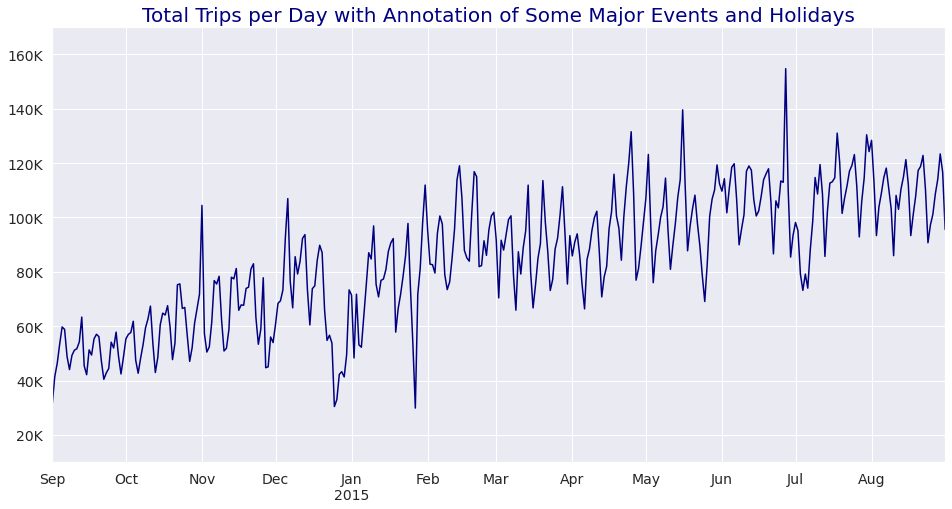

In [ ]:

fig = plt.figure()

ax = byDate.plot(figsize = (16, 8), fontsize = 12, ylim = (10000, 170000), color = 'navy')

formatter = FuncFormatter(thousands_format)
ax.yaxis.set_major_formatter(formatter)


plt.title('Total Trips per Day with Annotation of Some Major Events and Holidays', fontsize= 20, color='navy')
plt.tick_params(labelsize=14)
plt.xlabel('')






# The effect of time on demand for Uber rides: distribution per hour, weekday, and month.

In [ ]:
weekday_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
month_labels = ['Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


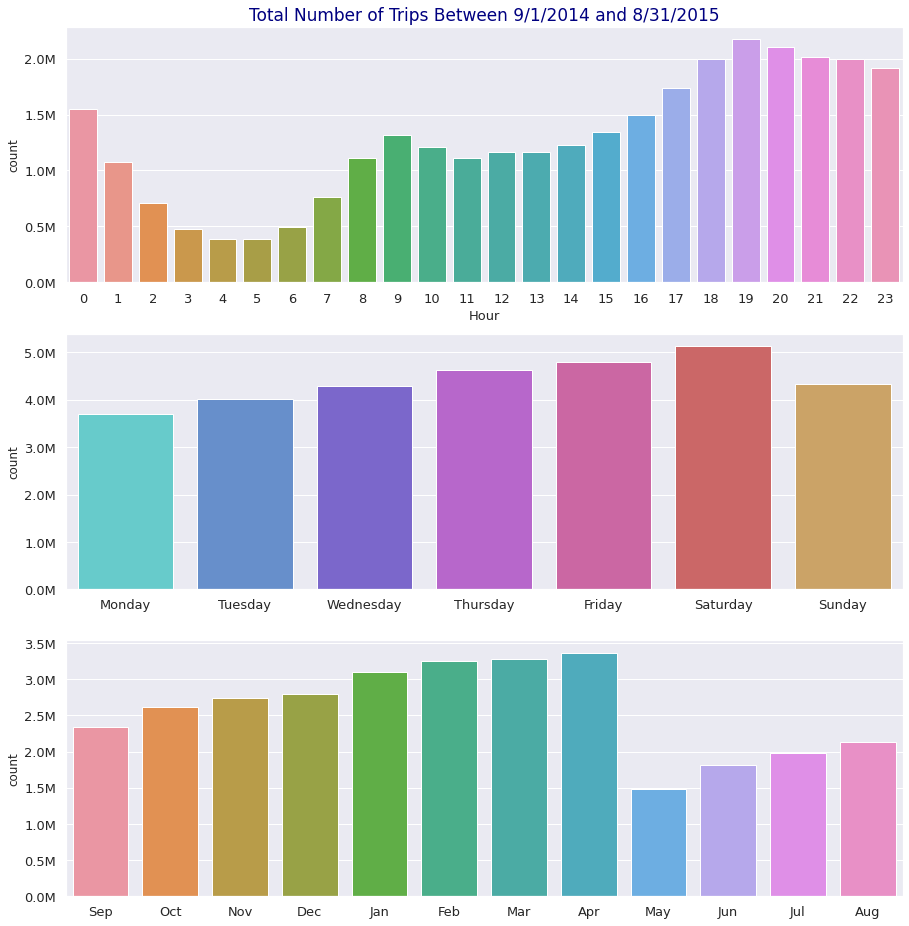

In [ ]:
# Create plots comparing demand per different time categories:
fig = plt.figure(figsize = (15,16))
formatter = FuncFormatter(millions_format)

plt.subplot(3,1,1) #this plot could have a polar format, although I'm not sure it'd be a better viz.
ax1 = sns.countplot(df_viz.hour, order = range(24))
ax1.yaxis.set_major_formatter(formatter)
plt.tick_params(labelsize=13)
plt.title('Total Number of Trips Between 9/1/2014 and 8/31/2015', fontsize=17, color='navy')
plt.xlabel('Hour', fontsize=13)

plt.subplot(3,1,2)
ax2 = sns.countplot(df_viz.weekday, order = range(7))
ax2.set_xticklabels(weekday_labels)
ax2.yaxis.set_major_formatter(formatter)
plt.tick_params(labelsize=13)
plt.xlabel('')

plt.subplot(3,1,3) #same as the line plot but with less granularity, perhaps easier to visualize the MOM growth
ax3 = sns.countplot(df_viz.month)
ax3.set_xticklabels(month_labels)
ax3.yaxis.set_major_formatter(formatter)
#plt.text(0, 3100000, 'Consistent growth in the number of trips from month to month!', color='navy', size=15)
plt.tick_params(labelsize=13)
plt.xlabel('')

#fig.subplots_adjust(hspace=.5)
plt.show()

# Estimated Monthly Base Revenue: how much was the NYC market worth in the period?

In [ ]:
#Create dataframe with grouped revenue data:
byDateRev = df_viz.groupby('month')['est_revenue'].sum()

In [ ]:
#Estimate Uber's gross margin for the entire 1 year period based on 25% share of the base revenue.
sumRev = byDateRev.sum()
print ('${:,.0f}M'.format(sumRev * 1e-6), "Base Revenue   Uber's Base Gross Margin:", '${:,.0f}'.format(sumRev * .25))

$595M Base Revenue   Uber's Base Gross Margin: $148,757,755


In [ ]:
#Estimated base gross margin based on information that average UberX fare in Sep 2014 was $27 (but it has dropped):
len(df_viz) * 27 * .25

208735400.25

In [ ]:
byDateRev.head()

month
1   41457151.3925
2   47252851.6517
3   52154385.1658
4   54095066.2220
5   61539912.0576
Name: est_revenue, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


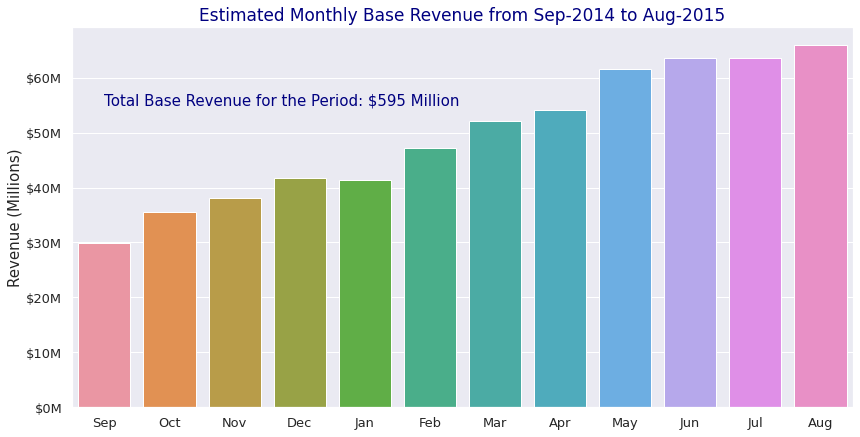

In [ ]:
#Create chart showing total base revenue per month.
months_seq = [9,10,11,12,1,2,3,4,5,6,7,8]
formatter = FuncFormatter(millions_currency)

plt.figure(figsize = (14, 7))
ax = sns.barplot(byDateRev.index, byDateRev.values, order = months_seq)
ax.set_xticklabels(month_labels)
ax.yaxis.set_major_formatter(formatter)

font = {'color': 'navy', 'size': 15} #text parameters
plt.text(0, 55000000, 'Total Base Revenue for the Period: ${:,.0f} Million'.format(sumRev * 1e-6), 
         fontdict = font) #params: x, y, text, fontdict
plt.xlabel('')
plt.ylabel('Revenue (Millions)', fontsize = 15)
plt.tick_params(labelsize=13)
plt.title('Estimated Monthly Base Revenue from Sep-2014 to Aug-2015', fontsize = 17, color='navy')

plt.show()

In [ ]:

#Mean fare from revenue estimate for the period: $19.24 (assumes all trips are Uber X)
df_viz.est_revenue.mean()

19.241869694747738

In [ ]:
#Rough estimate of revenue share from Uber Pool from 12/1/2014 to 8/31/2015 (total of 25,634,526 trips):
rev = df_viz[(df_viz.pu_date >= datetime.datetime(2014, 12, 1)) & (df_viz.pu_date <= datetime.datetime(2015, 8, 31))].est_revenue.mean() #$19.17 mean revenue
u_pool = rev * 0.75 * 1500000
u_pool #$21,565,512 estimated revenue

21565512.055648196

In [ ]:
u_pool/df_viz[(df_viz.pu_date >= datetime.datetime(2014, 12, 1)) & (df_viz.pu_date <= datetime.datetime(2015, 8, 31))].est_revenue.sum() #Uber Pool represented only about 4% of the total revenue for the period between Dec/14 and Aug/15.

0.04388612451814645

# Month over Month Base Revenue Growth: how fast has Uber grown in the period?

In [ ]:

#Create dictionary with calculated month over month revenue percentage growth:
dict_growth = {}
for i in range(len(months_seq)):
    mo = months_seq[i]
    rev = byDateRev[mo]
    if mo == 9:
        growth_pct = 0
    elif mo == 1:
        growth_pct = ((rev/byDateRev[12]) - 1) * 100
    else:
        growth_pct = ((rev/byDateRev[mo - 1]) - 1) * 100
    print (month_labels[i], 'Revenue =', '${:,.0f}'.format(rev), 'Growth % = ', '{:.1f}'.format(growth_pct))
    dict_growth[month_labels[i]] = growth_pct

Sep Revenue = $29,932,282 Growth % =  0.0
Oct Revenue = $35,531,001 Growth % =  18.7
Nov Revenue = $38,170,687 Growth % =  7.4
Dec Revenue = $41,661,569 Growth % =  9.1
Jan Revenue = $41,457,151 Growth % =  -0.5
Feb Revenue = $47,252,852 Growth % =  14.0
Mar Revenue = $52,154,385 Growth % =  10.4
Apr Revenue = $54,095,066 Growth % =  3.7
May Revenue = $61,539,912 Growth % =  13.8
Jun Revenue = $63,667,666 Growth % =  3.5
Jul Revenue = $63,607,348 Growth % =  -0.1
Aug Revenue = $65,961,099 Growth % =  3.7


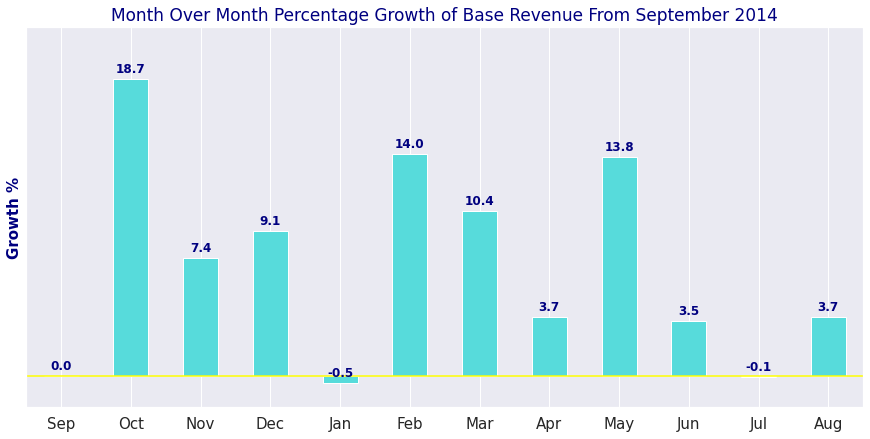

In [ ]:
#Annotate Total Cummulative Growth for the Period

df_plt1 = pd.DataFrame(pd.Series(dict_growth), index = month_labels, columns = ['growth_pct'])

labels_list = df_plt1.growth_pct.values.round(1)
kwargs = {'fontsize': 12, 'ha':'center', 'va': 'bottom', 'weight': 'bold', 'color': 'navy'}

ax = df_plt1.plot(kind = 'bar', figsize = (15,7), fontsize = 14, rot = 0, legend=False)#df_plt2[1:] to exclude Sep

ax.get_yaxis().set_ticks([])
annotate_labels(ax, labels_list, **kwargs)

plt.axhline(0, color='yellow')
plt.title('Month Over Month Percentage Growth of Base Revenue From September 2014', 
          fontsize = 17, color='navy')
plt.ylabel('Growth %', fontsize = 15, weight='bold', color='navy')
plt.ylim(-2, 22)
plt.tick_params(labelsize=15)

plt.show()

Cummulative % Growth Over Period:


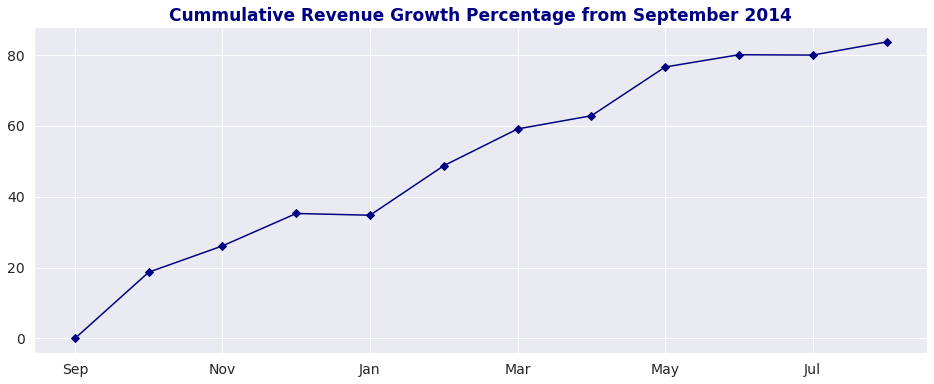

In [ ]:

#Plot Cummulative Base Revenue Growth Over the Period
print ('Cummulative % Growth Over Period:'), df_plt1.growth_pct.sum()

df_plt1.cumsum().plot(color = 'navy', marker = 'D', legend = False, figsize=(16, 6))
plt.title('Cummulative Revenue Growth Percentage from September 2014', fontsize=17, weight='bold', color='navy')
plt.tick_params(labelsize=14)
plt.show()

# Which day of the week has the worst (slowest) traffic overall?

In [ ]:
#Create dataframe with grouped data.
df_plt2 = df_viz.groupby('weekday')['trip_mph_avg'].median() #used median since distribution is skewed.

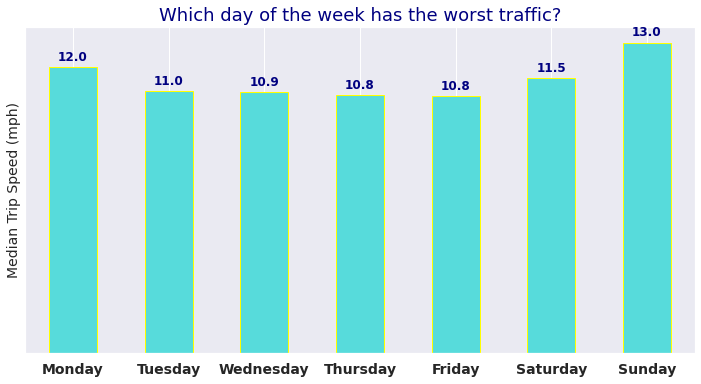

In [ ]:
#Create plot. Does Saturday have better traffic flow than Monday?

fig = plt.figure()
labels_list = df_plt2.values.round(1)
kwargs = {'fontsize': 12, 'ha':'center', 'va': 'bottom', 'weight': 'bold', 'color': 'navy'}

ax = df_plt2.plot(kind='bar', rot = 0, figsize = (12, 6), fontsize = 12, edgecolor='yellow', linewidth=1)
ax.set_xticklabels(weekday_labels, weight='bold')

ax.get_yaxis().set_ticks([])
annotate_labels(ax, labels_list, **kwargs)

plt.xlabel('')
plt.ylabel('Median Trip Speed (mph)', fontsize = 14)
plt.tick_params(labelsize=14)
plt.title('Which day of the week has the worst traffic?', fontsize = 18, color='navy')
plt.show()
#plot_url = py.plot_mpl(fig)

# What is the median distance traveled per trip? Are there any insights we can learn from it?

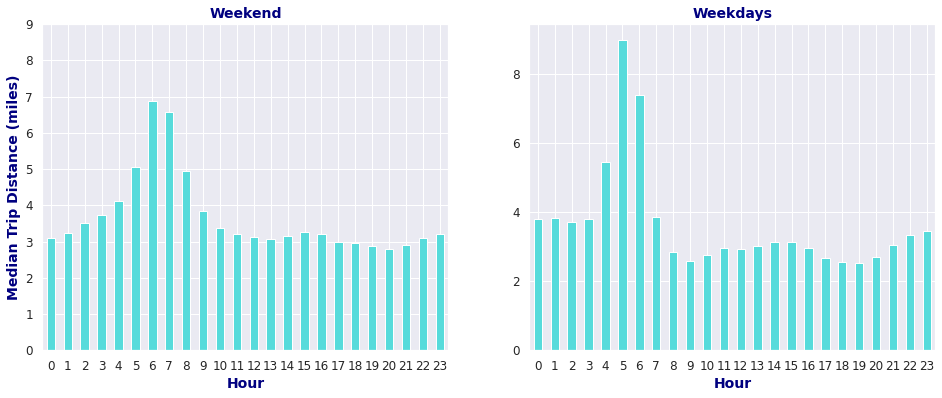

In [ ]:
#Why is the median distance traveled around 5 AM much longer than at the other times?
#Could it be picking up riders that would otherwise use public transportation to the outer boroughs? 
#While the subway runs 24/7 in NYC, bus services don't. It's clear though that most customer are within Manhattan.
plt.figure(figsize = (16,6))

plt.subplot(1,2,1)
df_viz[(df_viz.weekday >= 5)].groupby('hour')['trip_distance'].median().plot(kind='bar', rot = 0, fontsize=14)
plt.ylim(0, 9)
plt.tick_params(labelsize=12)
plt.ylabel('Median Trip Distance (miles)', fontsize=14, weight='bold', color='navy')
plt.xlabel('Hour', fontsize=14, weight='bold', color='navy')
plt.title('Weekend', fontsize=14, weight='bold', color='navy')

plt.subplot(1,2,2)
df_viz[df_viz.weekday < 5].groupby('hour')['trip_distance'].median().plot(kind='bar', rot = 0)
plt.tick_params(labelsize=12)
plt.xlabel('Hour', fontsize=14, weight='bold', color='navy')
plt.title('Weekdays', fontsize=14, weight='bold', color='navy')

plt.show()

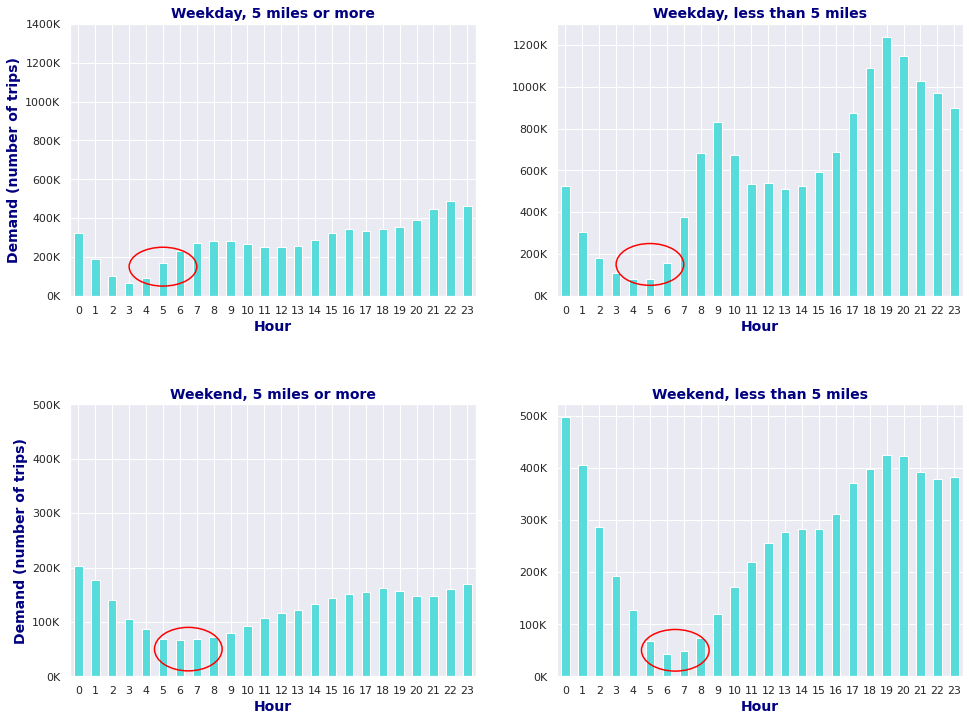

In [ ]:
#Create plot similar to the above but with the count of trips per hour, comparing weekday vs weekend and 
#distances >=5 versus < 5 miles. Indeed, the plots show that there is a higher demand for trips that go beyond 
#miles (outside Manhattan) from 5 to 7 AM on weekdays, and from 6 to 8 AM on weekends (Saturday and Sunday).

fig = plt.figure(figsize = (16,12))
formatter = FuncFormatter(thousands_format)


plt.subplot(2,2,1)
ax1 = df_viz[(df_viz.weekday < 5) & (df_viz.trip_distance >= 5)].\
groupby('hour')['trip_distance'].count().plot(kind='bar', rot = 0)
ax1.yaxis.set_major_formatter(formatter)
ellipse = Ellipse(xy=(5, 150000), width=4, height=200000, edgecolor='red', fc='None', lw=1.5)
ax1.add_patch(ellipse)
plt.xlabel('Hour', fontsize=14, weight='bold', color='navy')
plt.ylabel('Demand (number of trips)', fontsize=14, weight='bold', color='navy')
plt.ylim(0, 1400000)
plt.title('Weekday, 5 miles or more', fontsize=14, weight='bold', color='navy')

plt.subplot(2,2,2)
ax2 = df_viz[(df_viz.weekday < 5) & (df_viz.trip_distance < 5)].\
groupby('hour')['trip_distance'].count().plot(kind='bar', rot = 0)
ax2.yaxis.set_major_formatter(formatter)
ellipse = Ellipse(xy=(5, 150000), width=4, height=200000, edgecolor='red', fc='None', lw=1.5)
ax2.add_patch(ellipse)
plt.xlabel('Hour', fontsize=14, weight='bold', color='navy')
plt.title('Weekday, less than 5 miles', fontsize=14, weight='bold', color='navy')

plt.subplot(2,2,3)
ax3 = df_viz[(df_viz.weekday >= 5) & (df_viz.trip_distance >= 5)].\
groupby('hour')['trip_distance'].count().plot(kind='bar', rot = 0)
ax3.yaxis.set_major_formatter(formatter)
ellipse = Ellipse(xy=(6.5, 50000), width=4, height=80000, edgecolor='red', fc='None', lw=1.5)
ax3.add_patch(ellipse)
plt.xlabel('Hour', fontsize=14, weight='bold', color='navy')
plt.ylabel('Demand (number of trips)', fontsize=14, weight='bold', color='navy')
plt.ylim(0, 500000)
plt.title('Weekend, 5 miles or more', fontsize=14, weight='bold', color='navy')

plt.subplot(2,2,4)
ax4 = df_viz[(df_viz.weekday >= 5) & (df_viz.trip_distance < 5)].\
groupby('hour')['trip_distance'].count().plot(kind='bar', rot = 0)
ax4.yaxis.set_major_formatter(formatter)
ellipse = Ellipse(xy=(6.5, 50000), width=4, height=80000, edgecolor='red', fc='None', lw=1.5)
ax4.add_patch(ellipse)
plt.xlabel('Hour', fontsize=14, weight='bold', color='navy')
plt.title('Weekend, less than 5 miles', fontsize=14, weight='bold', color='navy')


fig.subplots_adjust(hspace=0.4)
plt.show()
#plot_url = py.plot_mpl(fig)

# What are the most popular pickup and drop-off taxi zones?

In [ ]:
#CREATE INSTEAD SIDE-STACKED PLOT WITH TOP 10 PICKUP AND DROP-OFF LOCATIONS? OR TRY TOYPLOT WITH VALUE FOR EACH BAR.

In [ ]:
#Percentage of trips represented by the top five origins/destinations:
print (df_viz.origin_taz.value_counts().head(5).sum()/float(len(df_viz))) #13,583,249
print (df_viz.destination_taz.value_counts().head(5).sum()/float(len(df_viz[df_viz.destination_taz.isnull() == False])))

0.43922264570453473
0.41584985632479493


In [ ]:

#Total pickups or drop-offs within any combination of the top 5 locations: 6231353 (20% of the total trips)
len(df_viz[(df_viz.origin_taz.isin(['2A', '15', '4C', '1', '6B']) == True) & \
           (df_viz.destination_taz.isin(['2A', '15', '4C', '1', '6B']) == True)])

6231353

In [ ]:
#29% of all trips start or finish at 2A:
len(df_viz[(df_viz.origin_taz == '2A') | (df_viz.destination_taz == '2A')])/(1.0*len(df_viz)) #8979830

0.2903860697677705

# Visualizing the most popular pick up and drop off location pairs.

In [ ]:
#Define data to plot:
df_plt3 = df_viz.pivot_table('id', aggfunc='count', index='origin_taz', columns='destination_taz')

In [ ]:
df_plt3.shape

(28, 29)

findfont: Font family ['Tahoma'] not found. Falling back to DejaVu Sans.


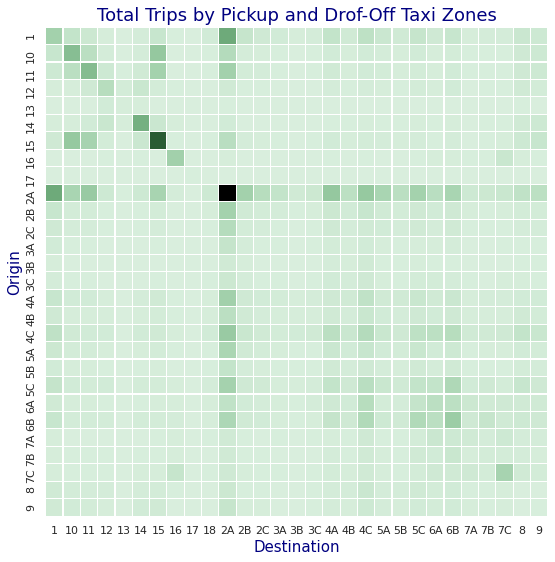

In [ ]:
#Visualize the origin versus destination matrix via a heatmap:

fig = plt.figure(figsize=(9,9))

cmap = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.9, as_cmap=True) #'YlOrRd' #ggplot:'viridis'

sns.heatmap(df_plt3, cmap=cmap, linewidths=0.1, cbar=False)

plt.title('Total Trips by Pickup and Drof-Off Taxi Zones', fontsize=18, color='navy')
plt.xlabel('Destination', fontsize=15, fontname='Tahoma', color='navy')
plt.ylabel('Origin', fontsize=15, fontname='Tahoma', color='navy')
plt.tick_params(labelsize=11)
plt.show()

In [ ]:
len(df_viz[(df_viz.origin_taz.isin(['2A', '15', '4C', '1', '6B']) == True) & \
           (df_viz.destination_taz.isin(['2A', '15', '4C', '1', '6B']) == True)])

6231353


# What is the mean time and distance to destination from the most popular pick up location?

In [ ]:
#Plot the mean travel time from the most popular origin, to all possible destinations.
df_plt4 = df_viz[df_viz.origin_taz == '2A'].groupby('destination_taz')['trip_distance'].mean().sort_values()
df_plt5 = df_viz[df_viz.origin_taz == '2A'].groupby('destination_taz')['duration_min'].mean().sort_values()

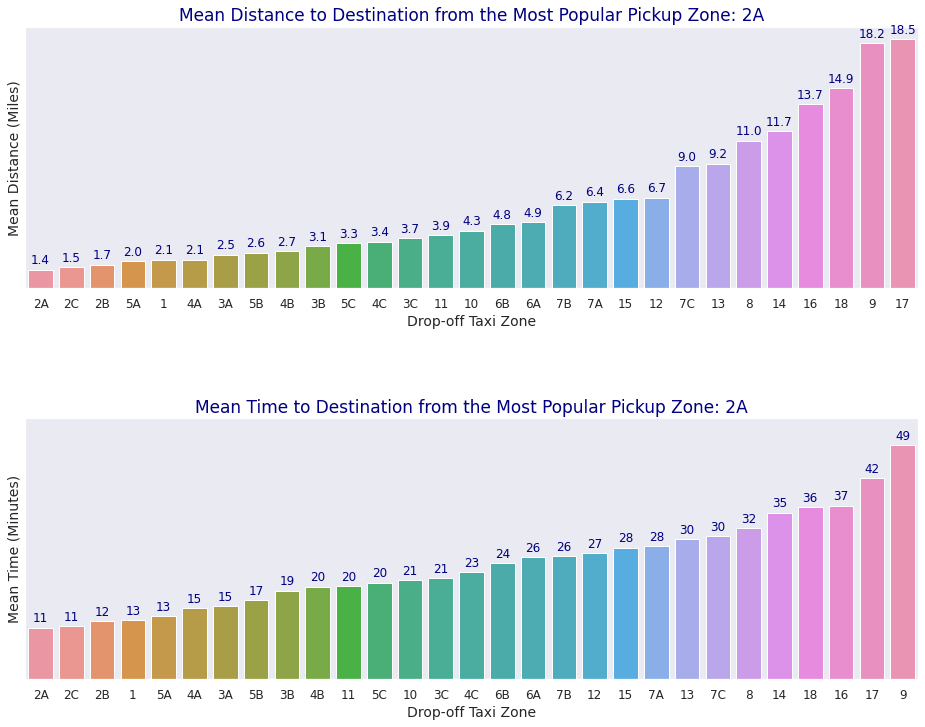

In [ ]:
#Assuming 18 is EWR, and given the average driving distance from 2A, this pick up location is probably located in 
#Midtown, not in Lower Manhattan (Penn Station lat/long: 40.750568, -73.993519)
#Straight line distance: 11 miles, Driving distance: 15 miles Difference: 36%
#The mean time and distance to zone 18 adds further evidence that it's the EWR airport (from Midtown).
#Based on the distance from 2A, if the origin is Midtown, then 15 is in Upper Manhattan.

fig = plt.figure(figsize = (16,12))
kwargs = {'fontsize': 12, 'ha':'center', 'va': 'bottom', 'color': 'navy'}


plt.subplot(2,1,1)
ax1 = sns.barplot(x=df_plt4.index, y=df_plt4.values)

#ax1.set_yticks(range(0, 21, 2))
ax1.get_yaxis().set_ticks([])
labels_list = df_plt4.values.round(1)
annotate_labels(ax1, labels_list, **kwargs)
plt.title('Mean Distance to Destination from the Most Popular Pickup Zone: 2A', fontsize=17, color='navy')
plt.ylabel('Mean Distance (Miles)', fontsize = 14)
plt.xlabel('Drop-off Taxi Zone', fontsize=14)
plt.tick_params(labelsize=12)


plt.subplot(2,1,2)
ax2 = sns.barplot(x=df_plt5.index, y=df_plt5.values)

#ax2.set_yticks(range(0, 51, 5))
ax2.get_yaxis().set_ticks([])
labels_list = df_plt5.apply(lambda x: '{:.0f}'.format(round(x))).values
annotate_labels(ax2, labels_list, **kwargs)
plt.title('Mean Time to Destination from the Most Popular Pickup Zone: 2A', fontsize=17, color='navy')
plt.ylabel('Mean Time (Minutes)', fontsize = 14)
plt.ylim(0,55)
plt.xlabel('Drop-off Taxi Zone', fontsize=14)
plt.tick_params(labelsize=12)


fig.subplots_adjust(hspace=.5)
plt.show()
#plot_url = py.plot_mpl(fig)


# Visualization of Variable Distributions and Bivariate Relationships.
# Distribution of trip distance

In [ ]:
df_viz.trip_distance.max(), df_uber.trip_distance.max()

(568.57, 2593.08)

In [ ]:
freq, bins_dist = np.histogram(df_viz.trip_distance, bins=10, range=(0, 25))
freq, bins_dist

(array([12709212,  8364039,  3566741,  2035261,  1296836,   672674,
          705998,   747728,   299927,   132566]),
 array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5, 25. ]))

In [ ]:
#69% of all trips had distance < 5 miles
for val in freq:
    print (float(val)/sum(freq))

0.4162726243132304
0.273952505032429
0.11682365801401344
0.06666215321865507
0.042476065787861
0.022032504555536406
0.023123985989052038
0.024490794301997885
0.009823693191394893
0.004342015595829836


In [ ]:
df_viz.trip_distance.median(), df_viz.trip_distance.mean()

(3.09, 5.199632456547355)

In [ ]:
print (len(df_viz[df_viz.trip_distance <= 5])/(1.0 *len(df_viz))) #68% of trips are 5 miles or less
print (len(df_viz[df_viz.trip_distance <= 2])/(1.0 *len(df_viz))) #32% of trips are 2 miles or less

0.6821384577290933
0.3192358898883037


In [ ]:
#Vey long distance trips (>= 300 miles):
df_viz[df_viz.trip_distance >= 300].head(10) #45 total

,id,origin_taz,destination_taz,trip_distance,pu_date,year,month,day,hour,weekday,duration_min,trip_mph_avg,est_revenue
943214,19594602,10,15,371.5500,2014-09-16,2014,9,16,10,1,474.2833,47.0035,818.7617
3620586,5138875,14,NaN,357.2700,2014-11-04,2014,11,4,23,1,309.5167,69.2570,736.1033
10581718,10072444,16,NaN,330.9000,2015-02-04,2015,2,4,18,2,648.5000,30.6153,808.6000
11224977,17353914,15,15,378.0100,2015-02-25,2015,2,25,15,2,600.7667,37.7528,874.3358
11684172,23119455,14,14,350.1500,2015-02-03,2015,2,3,18,1,559.3500,37.5597,811.0850
13829799,16426984,15,NaN,568.5700,2015-03-27,2015,3,27,19,4,652.3167,52.2970,1225.8583
16530542,15478567,7A,17,315.5700,2015-04-09,2015,4,9,1,3,248.0667,76.3271,641.6208
18643154,6860856,5C,16,308.4200,2015-05-31,2015,5,31,5,6,304.1833,60.8357,648.7492
18854980,9245564,15,15,302.7900,2015-05-10,2015,5,10,22,6,441.6667,41.1337,687.0158
18949729,10208984,4A,7C,335.3000,2015-05-09,2015,5,9,16,5,813.6667,24.7251,874.1083



# Distribution of trip duration (in minutes)

In [ ]:
#Median trip duration is ~ 17 minutes
df_viz.duration_min.describe()

count   30923763.0000
mean          20.9923
std           16.0846
min            0.0000
25%           10.8500
50%           17.2333
75%           26.6833
max          959.3000
Name: duration_min, dtype: float64

In [ ]:
freq, bins_dur = np.histogram(df_viz.duration_min, bins=10, range=(0, 50))
freq, bins_dur

(array([1235100, 5391133, 6311894, 5266617, 3929001, 2777037, 1878313,
        1256118,  852522,  589907]),
 array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.]))


# Plot of the histograms for trip distance and duration

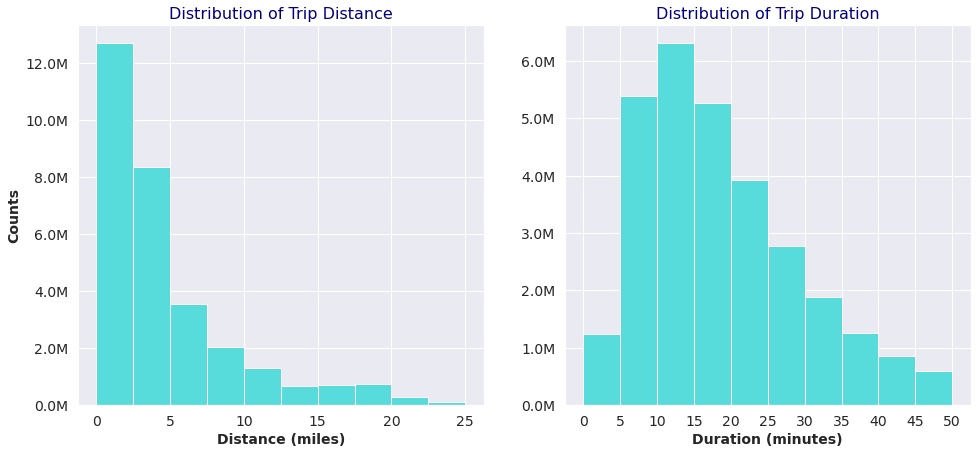

In [ ]:
#Here we plot the distribution of trip duration next to the histogram of trip distance for comparison.
fig = plt.figure(figsize=(16, 7))

formatter = FuncFormatter(millions_format)

plt.subplot(1,2,1)
ax1 = df_viz.trip_distance.dropna().hist(bins=bins_dist)
ax1.yaxis.set_major_formatter(formatter)

plt.xlabel('Distance (miles)', fontsize=14, weight='bold')
plt.ylabel('Counts', fontsize=14, weight='bold')
plt.tick_params(labelsize=14)
plt.title('Distribution of Trip Distance', color='navy', fontsize=16)


plt.subplot(1,2,2)
ax2 = df_viz.duration_min.hist(bins=bins_dur)
ax2.yaxis.set_major_formatter(formatter)
ax2.set_xticks(bins_dur) #bins are in 5 minutes intervals.

plt.xlabel('Duration (minutes)', fontsize=14, weight='bold')
plt.ylabel('')
plt.tick_params(labelsize=14)
plt.title('Distribution of Trip Duration', color='navy', fontsize=16)

plt.show()

# Trip Distance versus Trip Duration

In [ ]:
#Create data to plot with average distance and duration grouped by origin-destination location pairs:
df_plt6 = df_viz.groupby(['origin_taz', 'destination_taz'])['trip_distance', 'duration_min'].mean()
df_plt6.values

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


array([[ 1.4180704 , 10.56080168],
       [ 3.65081289, 17.97784922],
       [ 5.09364295, 22.49040273],
       ...,
       [19.84848465, 44.5050345 ],
       [12.19842835, 29.74001046],
       [ 2.52056516,  9.87329898]])

In [ ]:
df_plt6.shape #distance, duration (x, y): Fit function to replace 7 incorrect duration entries with estimate.

(812, 2)

findfont: Font family ['Tahoma'] not found. Falling back to DejaVu Sans.


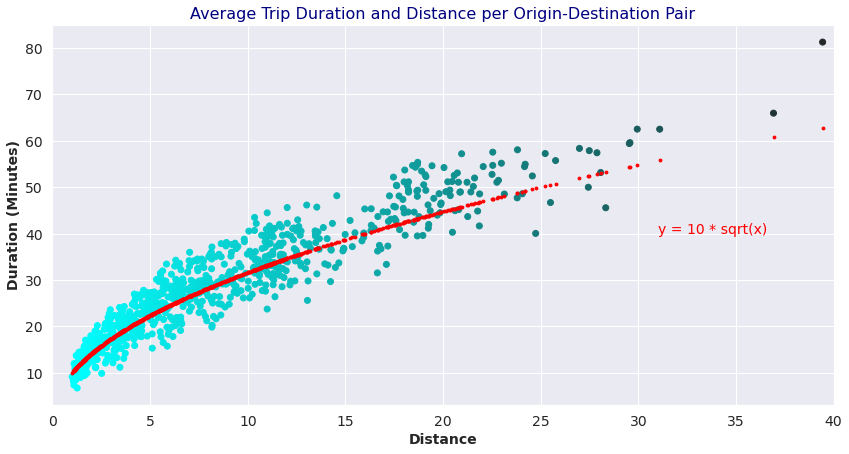

In [ ]:
#Create plot.
distance = df_plt6.values[:,:1]
duration = df_plt6.values[:,1:]
duration_hat = pd.Series(distance.reshape(812,)).apply(lambda x: 10*np.sqrt(x))

plt.figure(figsize = (14,7))
cmap = sns.dark_palette('cyan', 3, reverse = True, as_cmap=True)

plt.scatter(distance, duration, c=distance, cmap= cmap) # it looks like a 10*sqrt(x) power distribution
plt.scatter(distance, duration_hat, color='red', s=8)

font = {'color': 'red', 'size': 14, 'family': 'Tahoma'}
plt.text(31, 40, 'y = 10 * sqrt(x)', fontdict = font) 
plt.xlim(0, 40)
plt.xlabel('Distance', fontsize = 14, weight='bold')
plt.ylabel('Duration (Minutes)', fontsize = 14, weight='bold')
plt.tick_params(labelsize=14)
plt.title('Average Trip Duration and Distance per Origin-Destination Pair', fontsize = 16, color='navy')


plt.show()

In [ ]:

df_plt6[df_plt6.trip_distance > 25] #origin and destination pairs whose distance between them is greater than 25 miles

trip_distance  duration_min
origin_taz destination_taz                             
13         18                     28.0717       53.1685
14         17                     27.8808       57.4252
           18                     29.9431       62.5171
16         17                     31.0922       62.5046
           18                     28.3292       45.5679
17         14                     27.4876       57.8793
           16                     39.4353       81.2769
           7C                     25.2298       57.2576
           9                      25.5005       46.6947
7A         17                     29.5695       59.6055
7C         17                     26.9832       58.3610
8          17                     25.7619       55.7408
           18                     29.5376       59.4060
9          17                     27.4381       49.9894
           18                     36.9205       65.9577


# Distribution of the average speed per trip

In [ ]:
#Note: this uses processed data (24904 (0.08%) entries with null or zero in duration resulted in null value for speed)
df_viz.trip_mph_avg.describe()

count   30898897.0000
mean          13.5071
std           11.7569
min            0.0000
25%            8.4098
50%           11.4488
75%           16.2667
max        22548.0000
Name: trip_mph_avg, dtype: float64

In [ ]:
freq, bins = np.histogram(df_viz.trip_mph_avg, bins=10, range=(0, 50))
freq, bins

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 1313433, 10564782,  9861693,  4248216,  2152654,  1281911,
          767746,   434298,   196149,    61858]),
 array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.]))

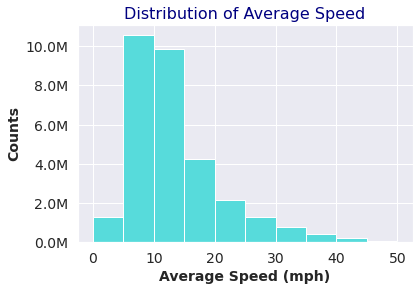

In [ ]:

fig, ax = plt.subplots(1,1)

formatter = FuncFormatter(millions_format)

ax.hist(df_viz.trip_mph_avg.dropna(), bins)
ax.yaxis.set_major_formatter(formatter)

plt.xlabel('Average Speed (mph)', fontsize=14, weight='bold')
plt.ylabel('Counts', fontsize=14, weight='bold')
plt.tick_params(labelsize=14)
plt.title('Distribution of Average Speed', color='navy', fontsize=16)
plt.show()

In [ ]:
#Median trip average speed during weekdays:
df_plt7 = df_viz[df_viz.weekday < 5].groupby('hour')['trip_mph_avg'].median()
df_plt7.head()

hour
0   14.3002
1   15.3747
2   16.1274
3   16.6125
4   19.5019
Name: trip_mph_avg, dtype: float64

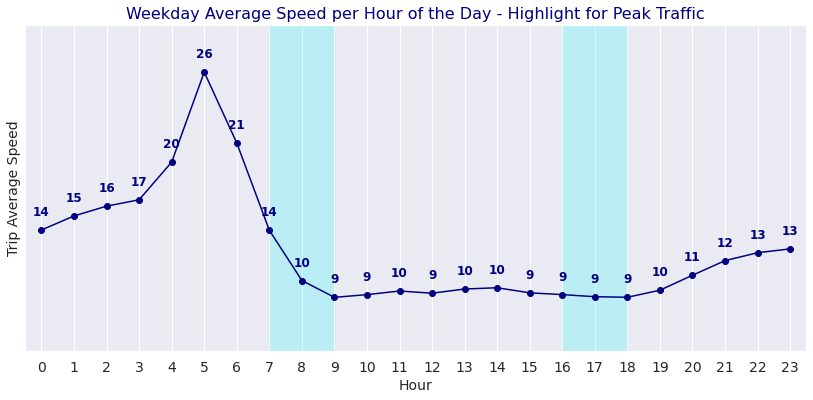

In [ ]:
#Plot Peak Hour Median Trip Average Speed During Weekdays:

plt.figure(figsize =(14, 6))
kwargs = {'fontsize': 12, 'ha':'center', 'va': 'top', 'color': 'navy', 'weight': 'bold'}

#weekdays only: rush hour traffic 7-9 + 16-18
ax = df_plt7.plot(marker = 'o', color = 'navy')

for x, y in zip(df_plt7.index, df_plt7.values):
    ax.annotate('{:.0f}'.format(y), xy=(x, y), xytext= (0, 24), textcoords='offset points', **kwargs)


ax.get_yaxis().set_ticks([]) #hide tick labels on y-axis
plt.fill([7,9,9,7], [0,0,30,30], 'cyan', alpha=0.2)
plt.fill([16,18,18,16], [0,0,30,30], 'cyan', alpha=0.2)
plt.xticks(range(24))
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Trip Average Speed', fontsize=14)
plt.ylim(5, 30)
plt.xlim(-0.5, 23.5)
plt.tick_params(labelsize=14)
plt.title('Weekday Average Speed per Hour of the Day - Highlight for Peak Traffic', fontsize = 16, color='navy')
plt.show()

In [ ]:

def is_peak_hour(x):
    """ 
    Function that takes an array(x) with two integers representing 
    hour of the day and weekday, respectively, and
    returns 1 if it's peak hour as defined, 0 otherwise.
    """
    return 1 if x[0] in (7,8,9,16,17,18) and x[1] < 5 else 0 #total peak hour periods = 6h

In [ ]:
df_viz['peak_hour'] = pd.Series(map(lambda x: is_peak_hour(x), df_viz.loc[:, ['hour', 'weekday']].values))

In [ ]:
df_viz.head()

,id,origin_taz,destination_taz,trip_distance,pu_date,year,month,day,hour,weekday,duration_min,trip_mph_avg,est_revenue,peak_hour
0,252581,7C,6A,4.2500,2014-09-01,2014,9,1,9,0,15.1833,16.7947,15.3017,1.0000
1,252582,7B,15,10.1700,2014-09-01,2014,9,1,18,0,34.0833,17.9032,32.2767,1.0000
2,252583,11,2A,4.0200,2014-09-01,2014,9,1,17,0,17.1000,14.1053,15.5700,1.0000
3,252584,3B,4A,1.4600,2014-09-01,2014,9,1,13,0,6.5333,13.4082,8.0000,0.0000
4,252585,2A,10,8.3100,2014-09-01,2014,9,1,14,0,26.2833,18.9702,26.2917,0.0000


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  if sys.path[0] == '':


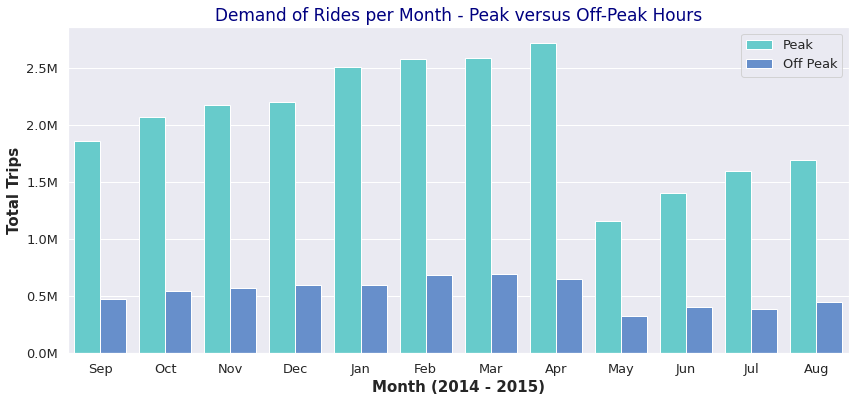

In [ ]:
#Plot the total number of trips per month during peak hours and off-peak hours.
#Count for peak hours must represent more than 25% (6h) of the total rides to be more significant than non-peak hours.
plt.figure(figsize = (14, 6))
formatter = FuncFormatter(millions_format)

#to add labels and operate on data, use pivot instead of countplot directly with hue.
ax = sns.countplot(df_viz['month'], hue = df_viz['peak_hour'])
ax.set_xticklabels(month_labels)
ax.yaxis.set_major_formatter(formatter)

handles, labels = ax.get_legend_handles_labels() #will cause the warning msg that can be ignored 
plt.legend(handles, labels=['Peak', 'Off Peak'], loc='best', fontsize=13)
plt.tick_params(labelsize=13)
plt.xlabel('Month (2014 - 2015)', fontsize = 15, weight='bold')
plt.ylabel('Total Trips', fontsize = 15, weight='bold')
plt.title('Demand of Rides per Month - Peak versus Off-Peak Hours', fontsize = 17, color='navy')
plt.show()

# Data Modeling (to be continued...)
# Join Weather Data.

In [ ]:
#Weather Data Key (Central Park, NYC Station):
#PRCP = precipitation in inches
#SNWD = snow depth in inches
#SNOW = snowfall in inches
#TMAX = max temperature in F (minimum of 2F for entire period from 2014 to 2015)
#TMIN = min temperature in F (maximum of 97F for the entire period from 2014 to 2015)
#AWND = average daily wind speed in MPH

In [ ]:
#Refer to data source. Use integrated weather data to forecast demand for rides.
weather = pd.read_csv('weather.csv', na_values = -9999, parse_dates = ['DATE'], \
                      usecols = [u'DATE', u'PRCP', u'SNWD', u'SNOW', u'TMAX', u'TMIN', u'AWND'])

In [ ]:
weather.columns = ['pu_date', 'prcp', 'snwd', 'snow', 'tmax', 'tmin', 'awnd']
weather.head()

,pu_date,prcp,snwd,snow,tmax,tmin,awnd
0,2014-01-01,0.0000,0.0000,0.0000,33,24,5.6000
1,2014-01-02,0.3300,0.0000,3.1000,33,18,12.3000
2,2014-01-03,0.2900,5.9000,3.3000,18,9,10.5000
3,2014-01-04,0.0000,5.9000,0.0000,29,8,4.9000
4,2014-01-05,0.1400,3.9000,0.0000,40,27,3.8000


In [ ]:
#There are some nan missing values for wind speed:
weather.awnd[24:27]

24   7.6000
25      nan
26   7.8000
Name: awnd, dtype: float64

In [ ]:
#Merge weather data
#avoiding unncessary sorting by key improves perfomance
df_merged = pd.merge(df_uber, weather, on='pu_date', how='left', sort=False)

In [ ]:
df_merged.head()

,id,origin_taz,destination_taz,trip_distance,pu_date,year,month,day,hour,weekday,duration_min,trip_mph_avg,est_revenue,prcp,snwd,snow,tmax,tmin,awnd
0,252581,7C,6A,4.2500,2014-09-01,2014,9,1,9,0,15.1833,16.7947,15.3017,0.0000,0.0000,0.0000,88,75,2.9000
1,252582,7B,15,10.1700,2014-09-01,2014,9,1,18,0,34.0833,17.9032,32.2767,0.0000,0.0000,0.0000,88,75,2.9000
2,252583,11,2A,4.0200,2014-09-01,2014,9,1,17,0,17.1000,14.1053,15.5700,0.0000,0.0000,0.0000,88,75,2.9000
3,252584,3B,4A,1.4600,2014-09-01,2014,9,1,13,0,6.5333,13.4082,8.0000,0.0000,0.0000,0.0000,88,75,2.9000
4,252585,2A,10,8.3100,2014-09-01,2014,9,1,14,0,26.2833,18.9702,26.2917,0.0000,0.0000,0.0000,88,75,2.9000


In [ ]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30925738 entries, 0 to 30925737
Data columns (total 19 columns):
 #   Column           Dtype         
---  ------           -----         
 0   id               int64         
 1   origin_taz       object        
 2   destination_taz  object        
 3   trip_distance    float64       
 4   pu_date          datetime64[ns]
 5   year             int64         
 6   month            int64         
 7   day              int64         
 8   hour             int64         
 9   weekday          int64         
 10  duration_min     float64       
 11  trip_mph_avg     float64       
 12  est_revenue      float64       
 13  prcp             float64       
 14  snwd             float64       
 15  snow             float64       
 16  tmax             int64         
 17  tmin             int64         
 18  awnd             float64       
dtypes: datetime64[ns](1), float64(8), int64(8), object(2)
memory usage: 4.6+ GB


In [ ]:
#Show all dataframes in the environment:
#%psearch df*